In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Markdown, display

# Datasets
from aif360.datasets import StandardDataset

# from PhysionetDataset.py import PhysionetDataset.py
# Dataset = PhysionetDataset.py


# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [19]:
#Physionet Dataset
#https://physionet.org/content/heart-failure-zigong/1.2/
np.random.seed(1)

default_mappings = {
    'label_maps': [{1.0: '1'}],
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}]
}


filepath = r'C:\Users\sujin\Documents\College\PhD_Project\Project\PhysioNet_NoColumns.csv'
        
filepath2 = r'C:\Users\sujin\Documents\College\PhD_Project\Project\PhysioNet_Columns.csv'
df2 = pd.read_csv(filepath2)
df2.columns

class PhysionetDataset(StandardDataset):

    def __init__(self, label_name='return.to.emergency.department.within.6.months',
                 favorable_classes=[1],
                 protected_attribute_names=['gender'],
                 privileged_classes=[[1]],
                 instance_weights_name=None,
                 categorical_features=['DestinationDischarge', 'admission.ward', 'admission.way',
                                       "occupation", "discharge.department", "visit.times",
                                       "type.of.heart.failure", "NYHA.cardiac.function.classification",
                                       'Killip.grade', "ageCat", "type.II.respiratory.failure", "consciousness",
                                       "respiratory.support.", "oxygen.inhalation", "outcome.during.hospitalization"],
                 features_to_keep=[], features_to_drop=["inpatient.number"],
                 na_values=[], custom_preprocessing=None,
                 metadata=default_mappings):


        column_names = df2.columns
        try:
            df = pd.read_csv(filepath, header=None, names=column_names,
                             na_values=na_values)
            
        except IOError as err:
            print("IOError: {}".format(err))
            print("To use this class, please download the following files:")
            print("\n\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data")
            print("\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc")
            print("\nand place them, as-is, in the folder:")
            print("\n\t{}\n".format(os.path.abspath(os.path.join(
                os.path.abspath(__file__), '..', '..', 'data', 'raw', 'german'))))
            import sys
            sys.exit(1)

        super(PhysionetDataset, self).__init__(df=df, label_name=label_name,
                                               favorable_classes=favorable_classes,
                                               protected_attribute_names=protected_attribute_names,
                                               privileged_classes=privileged_classes,
                                               instance_weights_name=instance_weights_name,
                                               categorical_features=categorical_features,
                                               features_to_keep=features_to_keep,
                                               features_to_drop=features_to_drop, na_values=na_values,
                                               custom_preprocessing=custom_preprocessing, metadata=metadata)


In [20]:
# 3.1. Load data & create splits for learning/validating/testing model¶


(dataset_orig_train, dataset_orig_val, dataset_orig_test) = PhysionetDataset().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_train.unprivileged_protected_attributes[sens_ind]]

privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_train.privileged_protected_attributes[sens_ind]]


def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes,
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)


describe(dataset_orig_train, dataset_orig_val, dataset_orig_test)

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_orig_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_train)

print(explainer_orig_panel19_train.disparate_impact())

<bound method NDFrame.head of       inpatient.number DestinationDischarge admission.ward admission.way  \
0               857781                 Home     Cardiology  NonEmergency   
1               743087                 Home     Cardiology  NonEmergency   
2               866418                 Home     Cardiology  NonEmergency   
3               775928                 Home     Cardiology     Emergency   
4               810128                 Home     Cardiology  NonEmergency   
...                ...                  ...            ...           ...   
2003            740689   HealthcareFacility    GeneralWard     Emergency   
2004            734280   HealthcareFacility    GeneralWard     Emergency   
2005            781004   HealthcareFacility     Cardiology     Emergency   
2006            744870              Unknown     Cardiology  NonEmergency   
2007            791864                 Home     Cardiology     Emergency   

         occupation discharge.department  visit.times  ge

#### Training Dataset shape

(1004, 129)


#### Validation Dataset shape

(602, 129)


#### Test Dataset shape

(402, 129)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['gender']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['gender', 'body.temperature', 'pulse', 'respiration', 'map', 'weight', 'height', 'BMI', 'myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease', 'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease', 'connective.tissue.disease', 'peptic.ulcer.disease', 'diabetes', 'moderate.to.severe.chronic.kidney.disease', 'hemiplegia', 'malignant.lymphoma', 'solid.tumor', 'liver.disease', 'AIDS', 'eye.opening', 'movement', 'fio2', 'acute.renal.failure', 'left.ventricular.end.diastolic.diameter.LV', 'creatinine.enzymatic.method', 'urea', 'uric.acid', 'glomerular.filtration.rate', 'cystatin', 'monocyte.ratio', 'lymphocyte.count', 'mean.hemoglobin.volume', 'mean.hemoglobin.concentration', 'mean.platelet.volume', 'basophil.count', 'eosinophil.count', 'hemoglobin', 'platelet.distribution.width', 'platelet.hematocrit', 'neutrophil.count', 'D.dimer', 'international.normalized.ratio', 'activated.partial.thromboplastin.time', 'thrombin.time', 'prothrombin.

In [21]:
# 3.2. Learning a Logistic Regression (LR) classifier on original data¶
# 3.2.1. Training LR model on original data

dataset = dataset_orig_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

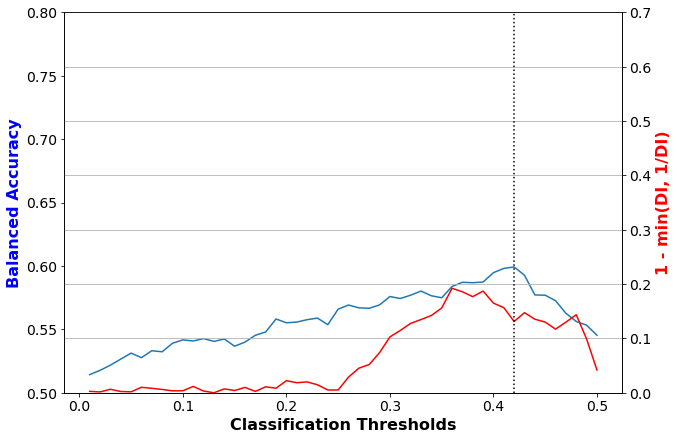

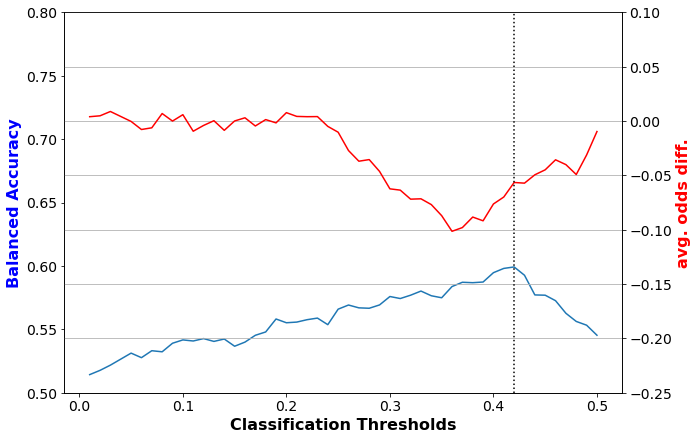

Validation Scores:
Threshold corresponding to Best balanced accuracy: 0.4200
Best balanced accuracy: 0.5992
Corresponding 1-min(DI, 1/DI) value: 0.1312
Corresponding average odds difference value: -0.0566
Corresponding statistical parity difference value: -0.0565
Corresponding equal opportunity difference value: -0.0609
Corresponding Theil index value: 0.2631


In [9]:
# 3.2.2. Validating LR model on original data¶

from collections import defaultdict


def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
            dataset, dataset_pred,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                       + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])


def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()
    
    
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1 / disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))


print("Validation Scores:")
describe_metrics(val_metrics, thresh_arr)

In [76]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Reweighing¶

#4.1. Transform data¶
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.4200
Best balanced accuracy: 0.5829
Corresponding 1-min(DI, 1/DI) value: 0.2061
Corresponding average odds difference value: -0.0848
Corresponding statistical parity difference value: -0.0902
Corresponding equal opportunity difference value: -0.0724
Corresponding Theil index value: 0.2638
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999996


Threshold corresponding to Best balanced accuracy: 0.4100
Best balanced accuracy: 0.5958
Corresponding 1-min(DI, 1/DI) value: 0.0195
Corresponding average odds difference value: -0.0033
Corresponding statistical parity difference value: -0.0080
Corresponding equal opportunity difference value: 0.0153
Corresponding Theil index value: 0.2618


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


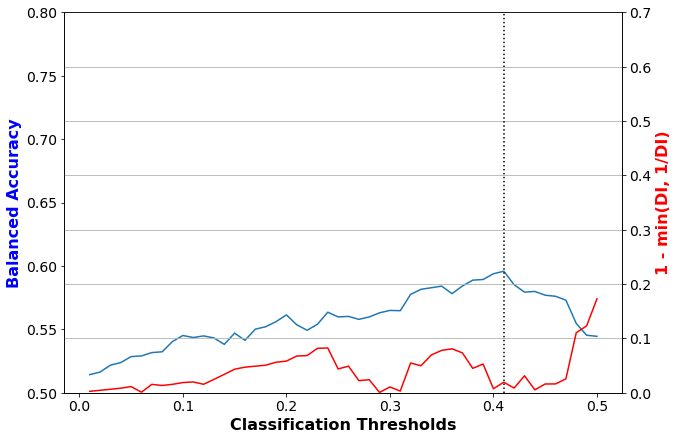

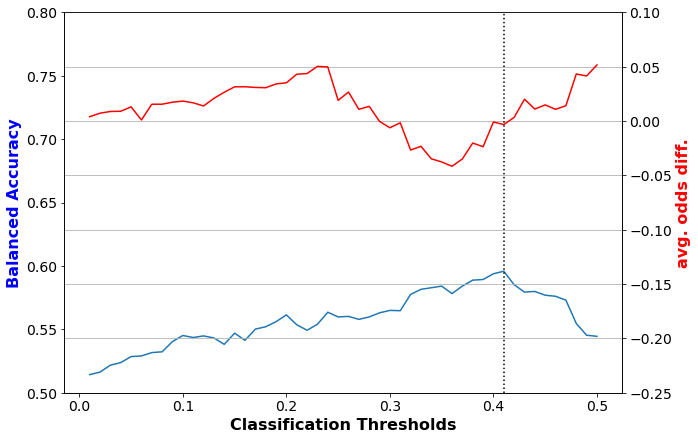

In [77]:
#4.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing¶

#4.2.1. Training LR model after reweighing¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after reweighing¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [78]:
#4.2.3. Testing LR model after reweighing¶
lr_transf_metrics = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])


Threshold corresponding to Best balanced accuracy: 0.4100
Best balanced accuracy: 0.5884
Corresponding 1-min(DI, 1/DI) value: 0.0833
Corresponding average odds difference value: -0.0315
Corresponding statistical parity difference value: -0.0355
Corresponding equal opportunity difference value: -0.0254
Corresponding Theil index value: 0.2524


Threshold corresponding to Best balanced accuracy: 0.2100
Best balanced accuracy: 0.5921
Corresponding 1-min(DI, 1/DI) value: 0.0555
Corresponding average odds difference value: 0.0317
Corresponding statistical parity difference value: 0.0368
Corresponding equal opportunity difference value: 0.0039
Corresponding Theil index value: 0.1591


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


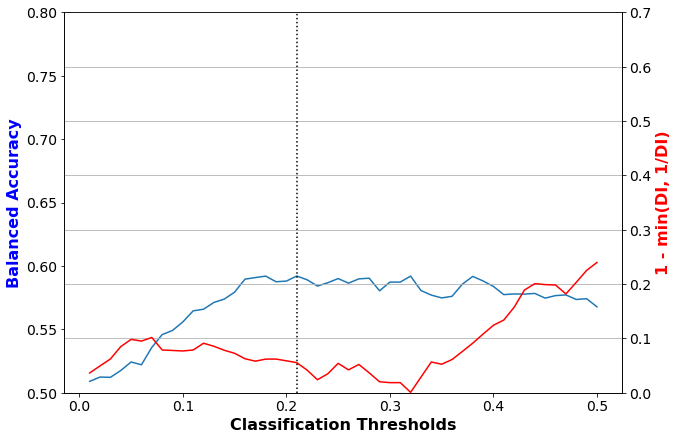

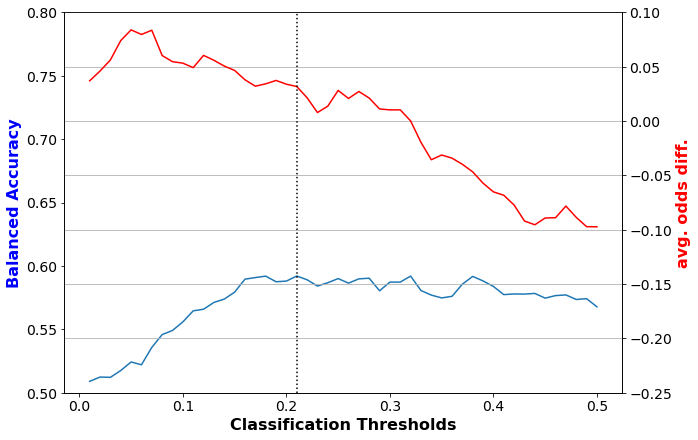

In [79]:
#5. Bias mitigation using in-processing technique - Prejudice Remover (PR)¶

#5.1.1. Training a PR model
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig = model.fit(dataset)

#5.1.2. Validating PR model¶

thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [80]:
#5.1.3. Testing PR model¶

dataset = dataset_orig_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2100
Best balanced accuracy: 0.5737
Corresponding 1-min(DI, 1/DI) value: 0.0409
Corresponding average odds difference value: 0.0264
Corresponding statistical parity difference value: 0.0283
Corresponding equal opportunity difference value: 0.0108
Corresponding Theil index value: 0.1476


In [81]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.582911,-0.084798,0.793933,-0.090230,-0.072426,0.263803
Reweighing,Logistic Regression,0.588429,-0.031474,0.916726,-0.035478,-0.025368,0.252357
Prejudice Remover,,0.573653,0.026369,1.042650,0.028265,0.010846,0.147566


In [82]:
#Disparate Impact Remover

from aif360.algorithms.preprocessing import DisparateImpactRemover


In [83]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Disparate Impact Remover¶

#4.1. Transform data¶


di = DisparateImpactRemover(repair_level=1.0)
dataset_transf_train = di.fit_transform(dataset_orig_train)
dataset_transf_test = di.fit_transform(dataset_orig_test)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.4200
Best balanced accuracy: 0.5829
Corresponding 1-min(DI, 1/DI) value: 0.2061
Corresponding average odds difference value: -0.0848
Corresponding statistical parity difference value: -0.0902
Corresponding equal opportunity difference value: -0.0724
Corresponding Theil index value: 0.2638
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.91140456182473


Threshold corresponding to Best balanced accuracy: 0.4000
Best balanced accuracy: 0.5965
Corresponding 1-min(DI, 1/DI) value: 0.2230
Corresponding average odds difference value: -0.1163
Corresponding statistical parity difference value: -0.1166
Corresponding equal opportunity difference value: -0.1184
Corresponding Theil index value: 0.2399


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


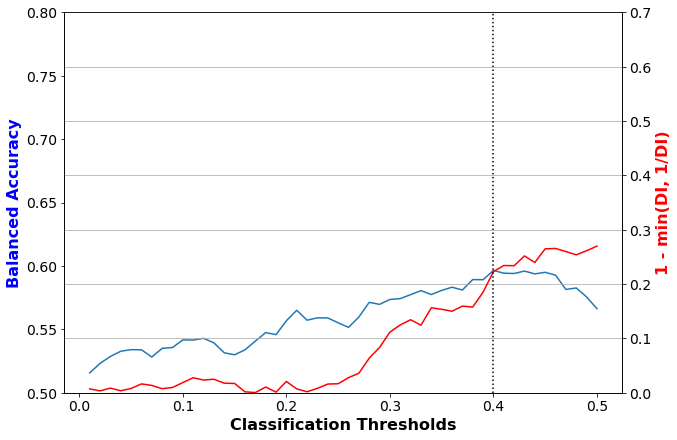

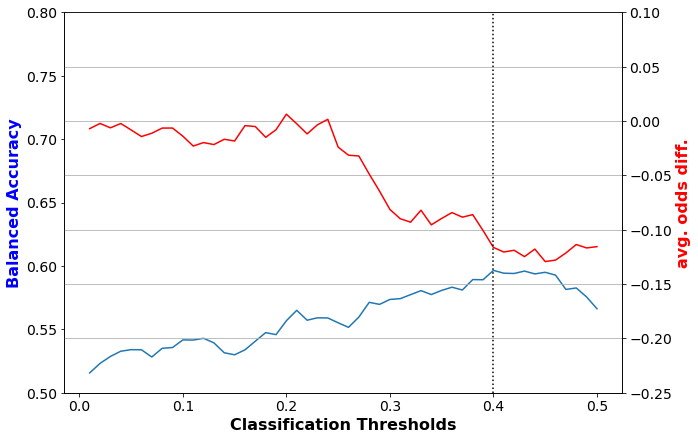

In [84]:
#4.2.1. Training LR model after Disparate Impact Remover¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after Disdparate impact Remover¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)

In [85]:
#Test LR DIR Model

lr_metrics_DIR = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_metrics_DIR, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.4000
Best balanced accuracy: 0.5957
Corresponding 1-min(DI, 1/DI) value: 0.2973
Corresponding average odds difference value: -0.1670
Corresponding statistical parity difference value: -0.1689
Corresponding equal opportunity difference value: -0.1699
Corresponding Theil index value: 0.2219


In [86]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.582911,-0.084798,0.793933,-0.090230,-0.072426,0.263803
Reweighing,Logistic Regression,0.588429,-0.031474,0.916726,-0.035478,-0.025368,0.252357
Prejudice Remover,,0.573653,0.026369,1.042650,0.028265,0.010846,0.147566
Disparate Impact Remover,Logistic Regression,0.595697,-0.167005,0.702656,-0.168906,-0.169853,0.221920


In [87]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import MaxAbsScaler
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.036205
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.013891


In [88]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.036205
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.013891


In [89]:
#Learn plan classifier without debiasing
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

plain_model.fit(dataset_orig_train)


epoch 0; iter: 0; batch classifier loss: 0.673327
epoch 1; iter: 0; batch classifier loss: 0.686832
epoch 2; iter: 0; batch classifier loss: 0.699498
epoch 3; iter: 0; batch classifier loss: 0.609149
epoch 4; iter: 0; batch classifier loss: 0.614318
epoch 5; iter: 0; batch classifier loss: 0.583147
epoch 6; iter: 0; batch classifier loss: 0.584280
epoch 7; iter: 0; batch classifier loss: 0.618432
epoch 8; iter: 0; batch classifier loss: 0.626918
epoch 9; iter: 0; batch classifier loss: 0.570964
epoch 10; iter: 0; batch classifier loss: 0.617173
epoch 11; iter: 0; batch classifier loss: 0.587663
epoch 12; iter: 0; batch classifier loss: 0.599606
epoch 13; iter: 0; batch classifier loss: 0.549663
epoch 14; iter: 0; batch classifier loss: 0.546140
epoch 15; iter: 0; batch classifier loss: 0.541502
epoch 16; iter: 0; batch classifier loss: 0.580891
epoch 17; iter: 0; batch classifier loss: 0.602328
epoch 18; iter: 0; batch classifier loss: 0.621864
epoch 19; iter: 0; batch classifier loss:

In [90]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [91]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Statisticsal parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

metrics_AD = defaultdict(list,
            {'bal_acc': [bal_acc_nodebiasing_test],
             'avg_odds_diff': [classified_metric_nodebiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_nodebiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_nodebiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_nodebiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_nodebiasing_test.theil_index()]})


#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.078624
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.048429


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.626866
Test set: Balanced classification accuracy = 0.560098
Test set: Average odds difference = -0.057676
Test set: Disparate impact = 0.809662
Test set: Statisticsal parity difference = -0.048429
Test set: Equal opportunity difference = -0.100551
Test set: Theil_index = 0.341187


In [92]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR, metrics_AD]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"] + ["Adversarial Debias"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"] + ["No Debias"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.582911,-0.084798,0.793933,-0.090230,-0.072426,0.263803
Reweighing,Logistic Regression,0.588429,-0.031474,0.916726,-0.035478,-0.025368,0.252357
Prejudice Remover,,0.573653,0.026369,1.042650,0.028265,0.010846,0.147566
Disparate Impact Remover,Logistic Regression,0.595697,-0.167005,0.702656,-0.168906,-0.169853,0.221920
Adversarial Debias,No Debias,0.560098,-0.057676,0.809662,-0.048429,-0.100551,0.341187


In [93]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
debiased_model.fit(dataset_orig_train)


epoch 0; iter: 0; batch classifier loss: 0.679520; batch adversarial loss: 0.700189
epoch 1; iter: 0; batch classifier loss: 0.662756; batch adversarial loss: 0.702133
epoch 2; iter: 0; batch classifier loss: 0.662859; batch adversarial loss: 0.727849
epoch 3; iter: 0; batch classifier loss: 0.661263; batch adversarial loss: 0.710588
epoch 4; iter: 0; batch classifier loss: 0.638472; batch adversarial loss: 0.679105
epoch 5; iter: 0; batch classifier loss: 0.646623; batch adversarial loss: 0.714690
epoch 6; iter: 0; batch classifier loss: 0.633157; batch adversarial loss: 0.668078
epoch 7; iter: 0; batch classifier loss: 0.605498; batch adversarial loss: 0.711883
epoch 8; iter: 0; batch classifier loss: 0.641088; batch adversarial loss: 0.725256
epoch 9; iter: 0; batch classifier loss: 0.626826; batch adversarial loss: 0.704126
epoch 10; iter: 0; batch classifier loss: 0.583959; batch adversarial loss: 0.729024
epoch 11; iter: 0; batch classifier loss: 0.593480; batch adversarial loss:

In [94]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [95]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())





display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

metrics_AD2 = defaultdict(list,
            {'bal_acc': [bal_acc_debiasing_test],
             'avg_odds_diff': [classified_metric_debiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_debiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_debiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_debiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_debiasing_test.theil_index()]})

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.078624
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.048429


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.102253
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.076974


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.626866
Test set: Balanced classification accuracy = 0.560098
Test set: Disparate impact = 0.809662
Test set: Equal opportunity difference = -0.100551
Test set: Average odds difference = -0.057676
Test set: Theil_index = 0.341187


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.621891
Test set: Balanced classification accuracy = 0.561663
Test set: Disparate impact = 0.739828
Test set: Equal opportunity difference = -0.108272
Test set: Average odds difference = -0.081967
Test set: Theil_index = 0.330792


In [125]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            lr_metrics_DIR,pr_orig_metrics, metrics_AD, metrics_AD2]
debias = pd.Series(['None'] + ['Reweighing']
                 + ["Disparate Impact Remover"] + ['Prejudice Remover']+ ["Adversarial Debias"]*2,
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*4 + ["GD(No Debias)"] +["GD(Debased)"],
                name='Classifier')
final_df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])
final_df

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.582911,-0.084798,0.793933,-0.090230,-0.072426,0.263803
Reweighing,Logistic Regression,0.588429,-0.031474,0.916726,-0.035478,-0.025368,0.252357
Disparate Impact Remover,Logistic Regression,0.595697,-0.167005,0.702656,-0.168906,-0.169853,0.221920
Prejudice Remover,Logistic Regression,0.573653,0.026369,1.042650,0.028265,0.010846,0.147566
Adversarial Debias,GD(No Debias),0.560098,-0.057676,0.809662,-0.048429,-0.100551,0.341187
Adversarial Debias,GD(Debased),0.561663,-0.081967,0.739828,-0.076974,-0.108272,0.330792


In [126]:
final_df.to_pickle("HeartFailure_Results_Pickle")
pickle = pd.read_pickle("HeartFailure_Results_Pickle")
pickle

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.582911,-0.084798,0.793933,-0.090230,-0.072426,0.263803
Reweighing,Logistic Regression,0.588429,-0.031474,0.916726,-0.035478,-0.025368,0.252357
Disparate Impact Remover,Logistic Regression,0.595697,-0.167005,0.702656,-0.168906,-0.169853,0.221920
Prejudice Remover,Logistic Regression,0.573653,0.026369,1.042650,0.028265,0.010846,0.147566
Adversarial Debias,GD(No Debias),0.560098,-0.057676,0.809662,-0.048429,-0.100551,0.341187
Adversarial Debias,GD(Debased),0.561663,-0.081967,0.739828,-0.076974,-0.108272,0.330792
